In [1]:
!pip install opendp-smartnoise==0.1.3.1
!pip show azureml-explain-model azureml-interpret
!pip show azureml-contrib-fairness
!pip install --upgrade fairlearn==0.5.0
!pip install opendp-smartnoise-core


import azureml.core
from azureml.core import Workspace
from azureml.core import Experiment
import pandas as pd
import matplotlib.pyplot as plt
from azureml.widgets import RunDetails
from azureml.core import Run
from azureml.core import Experiment, ScriptRunConfig
from azureml.widgets import RunDetails
import sys
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
from azureml.core import Workspace
from azureml.core import Dataset
import numpy as np
import joblib
import os
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import argparse
from sklearn.model_selection import train_test_split
from azureml.core import Run, Model
from azureml.core import Experiment
from azureml.pipeline.core import Pipeline
from azureml.widgets import RunDetails

from azureml.core import Experiment, ScriptRunConfig, Environment
from azureml.core.conda_dependencies import CondaDependencies
from azureml.train.hyperdrive import GridParameterSampling,BayesianParameterSampling, HyperDriveConfig, PrimaryMetricGoal, choice
from azureml.widgets import RunDetails


from interpret.ext.blackbox import TabularExplainer
import os, shutil
from azureml.interpret import ExplanationClient
from fairlearn.widget import FairlearnDashboard
from azureml.core import Datastore, Dataset

from azureml.widgets import RunDetails

from fairlearn.reductions import GridSearch, EqualizedOdds

from fairlearn.metrics._group_metric_set import _create_group_metric_set
from azureml.contrib.fairness import upload_dashboard_dictionary, download_dashboard_by_upload_id
from fairlearn.metrics._group_metric_set import _create_group_metric_set
from azureml.contrib.fairness import upload_dashboard_dictionary, download_dashboard_by_upload_id

from sklearn.metrics import accuracy_score, recall_score, precision_score


from azureml.core import Experiment, ScriptRunConfig, Environment
from azureml.core.conda_dependencies import CondaDependencies
from azureml.widgets import RunDetails

from azureml.datadrift import DataDriftDetector
from sklearn.tree import DecisionTreeClassifier


%matplotlib inline 

Name: azureml-explain-model
Version: 1.26.0
Summary: Machine Learning explain model package is used to interpret ML models
Home-page: https://docs.microsoft.com/python/api/overview/azure/ml/?view=azure-ml-py
Author: Microsoft Corp
Author-email: None
License: https://aka.ms/azureml-sdk-license
Location: /anaconda/envs/azureml_py36/lib/python3.6/site-packages
Requires: azureml-interpret
Required-by: 
---
Name: azureml-interpret
Version: 1.26.0
Summary: Machine Learning interpret package is used to interpret ML models
Home-page: https://docs.microsoft.com/python/api/overview/azure/ml/?view=azure-ml-py
Author: Microsoft Corp
Author-email: None
License: https://aka.ms/azureml-sdk-license
Location: /anaconda/envs/azureml_py36/lib/python3.6/site-packages
Requires: interpret-core, azureml-core, interpret-community
Required-by: azureml-train-automl-runtime, azureml-explain-model
Name: azureml-contrib-fairness
Version: 1.26.0
Summary: Uploads fairness dashboards to AzureML (preview)
Home-page: h

preparing folder etc


In [2]:
# Load the workspace from the saved config file
ws = Workspace.from_config()
#Create a tabular dataset from the path on the datastore (this may take a short while)
tab_data_set = Dataset.get_by_name(ws,  'mainMlDataSet', version = 1)
mainPdFrame = tab_data_set.take(100).to_pandas_dataframe()
mainPdFrame

INFO:azureml.core.workspace:Found the config file in: /config.json
INFO:azureml.core.run:Could not load the run context. Logging offline


,isStudy,SuvInFocus,TBR,simplifiedClassification,prosthesisType,ageInYearsWhenSurgery,gender,isMale
0,True,16.00,8.888888889,Y,stentgraft,77.196237,Mężczyzna,1
1,True,21.50,15.35714286,Y,stentgraft,68.016129,Mężczyzna,1
2,True,7.60,3.166666667,Y,proteza,60.725806,Kobieta,0
3,True,9.00,3.214285714,Y,proteza,52.720430,Kobieta,0
4,True,17.00,8.095238095,Y,stentgraft,77.129032,Mężczyzna,1
5,True,6.19,2.476,Y,proteza,69.129032,Mężczyzna,1
6,True,9.00,3.75,Y,proteza,53.155914,Mężczyzna,1
7,True,13.00,6.5,Y,proteza,45.572581,Kobieta,0
8,True,6.70,2.576923077,Y,proteza,74.674731,Mężczyzna,1
9,True,12.00,5,Y,proteza,56.459677,Mężczyzna,1


In [3]:
# Create a folder for the pipeline step files
experiment_folder = 'VascProsth_Experiment'
os.makedirs(experiment_folder, exist_ok=True)
# Get the experiment run context
run = Run.get_context()
print(experiment_folder)

INFO:azureml.core.run:Could not load the run context. Logging offline


VascProsth_Experiment


In [4]:
#Creating Experiment

prepare data

In [5]:

def prepareFrame (df):
    #filling nulls with mean
    df= df.fillna(df.mean())

    # Normalize the numeric columns
    scaler = MinMaxScaler()
    num_cols = ['SuvInFocus','TBR','ageInYearsWhenSurgery']
    df[num_cols] = scaler.fit_transform(df[num_cols])
    #setting categorical columns to boolean  - as here we basically care only about two columns
    df.loc[df['prosthesisType'] == "stentgraft", 'isStentgraft'] = True 
    df.loc[df['simplifiedClassification'] == "Y", 'isY'] = True 

    df.loc[df['prosthesisType'] != "stentgraft", 'isStentgraft'] = False 
    df.loc[df['simplifiedClassification'] != "Y", 'isY'] = False 


    df["isMale"] = df["isMale"].astype(bool)
    return df


mainPdFrame= pd.DataFrame(data= prepareFrame(mainPdFrame))
mainPdFrame


,isStudy,SuvInFocus,TBR,simplifiedClassification,prosthesisType,ageInYearsWhenSurgery,gender,isMale,isStentgraft,isY
0,True,0.7250,0.556590,Y,stentgraft,0.886475,Mężczyzna,True,True,True
1,True,1.0000,1.000000,Y,stentgraft,0.689679,Mężczyzna,True,True,True
2,True,0.3050,0.164322,Y,proteza,0.533395,Kobieta,True,False,True
3,True,0.3750,0.167587,Y,proteza,0.361782,Kobieta,True,False,True
4,True,0.7750,0.502184,Y,stentgraft,0.885034,Mężczyzna,True,True,True
5,True,0.2345,0.116976,Y,proteza,0.713537,Mężczyzna,True,False,True
6,True,0.3750,0.204311,Y,proteza,0.371117,Mężczyzna,True,False,True
7,True,0.5750,0.392828,Y,proteza,0.208552,Kobieta,True,False,True
8,True,0.2600,0.123894,Y,proteza,0.832421,Mężczyzna,True,False,True
9,True,0.5250,0.290000,Y,proteza,0.441941,Mężczyzna,True,False,True


Gradient boosting with hyperparameter tuning


In [6]:
%%writefile $experiment_folder/vascProsth_training.py
# this is important as this cell will be written to separate python file
# Import libraries


import argparse, joblib, os
from azureml.core import Run
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.preprocessing import MinMaxScaler

from sklearn.tree import DecisionTreeClassifier




def prepareFrame (df):
    #filling nulls with mean
    df= df.fillna(df.mean())

    # Normalize the numeric columns
    scaler = MinMaxScaler()
    num_cols = ['SuvInFocus','TBR','ageInYearsWhenSurgery']
    df[num_cols] = scaler.fit_transform(df[num_cols])
    #setting categorical columns to boolean  - as here we basically care only about two columns
    df.loc[df['prosthesisType'] == "stentgraft", 'isStentgraft'] = True 
    df.loc[df['simplifiedClassification'] == "Y", 'isY'] = True 

    df.loc[df['prosthesisType'] != "stentgraft", 'isStentgraft'] = False 
    df.loc[df['simplifiedClassification'] != "Y", 'isY'] = False 


    df["isMale"] = df["isMale"].astype(bool)
    return df





# Get the experiment run context
run = Run.get_context()

#learning_rate = 0.1
#n_estimators =100

################ part below to set arguments when this python file will be called

# Get script arguments
parser = argparse.ArgumentParser()

# Input dataset
parser.add_argument("--input-data", type=str, dest='input_data', help='training dataset')

############ Hyperparameters


#from https://medium.datadriveninvestor.com/decision-tree-adventures-2-explanation-of-decision-tree-classifier-parameters-84776f39a28
#max_depth: int or None, optional (default=None) [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15]


#min_samples_split: int, float, optional (default=2) [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15]


#min_impurity_decrease   [0.00005,0.0001,0.0002,0.0005,0.001,0.0015,0.002,0.005,0.01]


parser.add_argument('--max_depth', type=int, dest='max_depth', default=15, help='max_depth')
parser.add_argument('--min_samples_split', type=int, dest='min_samples_split', default=2, help='min_samples_split')
parser.add_argument('--min_impurity_decrease', type=float, dest='min_impurity_decrease', default=0.00005, help='min_impurity_decrease')
parser.add_argument('--isToExplain', type=bool, dest='isToExplain', default=False , help='true if it is a model we want to interpret - the best model')

# Add arguments to args collection
args = parser.parse_args()



mainPdFr = run.input_datasets['training_data'].to_pandas_dataframe() # Get the training data from the estimator input
mainPdFr= prepareFrame(mainPdFr)
#################### preapre data

# Separate features and labels
X, y = mainPdFr[
    ['SuvInFocus','TBR','isStentgraft','isY','ageInYearsWhenSurgery'
     ,'isMale']].values, mainPdFr['isStudy'].values

# Split data into training set and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=0)


################ model
model = DecisionTreeClassifier(max_depth =args.max_depth,
                                min_samples_split= args.min_samples_split,
                               min_impurity_decrease= args.min_impurity_decrease
                                                       ).fit(X_train, y_train)


########################## metrics


# calculate accuracy
y_hat = model.predict(X_test)
acc = np.average(y_hat == y_test)
print('Accuracy:', acc)
run.log('Accuracy', np.float(acc))

# calculate AUC
y_scores = model.predict_proba(X_test)
auc = roc_auc_score(y_test,y_scores[:,1])
print('AUC: ' + str(auc))
run.log('AUC', np.float(auc))

######################## Save the model in the run outputs
os.makedirs('outputs', exist_ok=True)
joblib.dump(value=model, filename='outputs/vascProsth_model.pkl')

########## explanations used only in best case
if(args.isToExplain):
    from interpret.ext.blackbox import TabularExplainer
    import os, shutil
    from azureml.interpret import ExplanationClient
    # Get explanation
    explainer = TabularExplainer(model, X_train, features=['SuvInFocus','TBR','isStentgraft','isY','ageInYearsWhenSurgery'
         ,'isMale'], classes=['noInfection', 'infection'])
    explanation = explainer.explain_global(X_test)

    # Get an Explanation Client and upload the explanation
    explain_client = ExplanationClient.from_run(run)
    explain_client.upload_model_explanation(explanation, comment='Tabular Explanation')



run.complete()

Overwriting VascProsth_Experiment/vascProsth_training.py


In [7]:
############# preparing compute enviroment
from azureml.core.compute import ComputeTarget, AmlCompute
from azureml.core.compute_target import ComputeTargetException

cluster_name = "main"

try:
    # Check for existing compute target
    training_cluster = ComputeTarget(workspace=ws, name=cluster_name)
    print('Found existing cluster, use it.')
except ComputeTargetException:
    # If it doesn't already exist, create it
    try:
        compute_config = AmlCompute.provisioning_configuration(vm_size='STANDARD_D2S_V3', max_nodes=2)
        training_cluster = ComputeTarget.create(ws, cluster_name, compute_config)
        training_cluster.wait_for_completion(show_output=True)
    except Exception as ex:
        print(ex)
    

Found existing cluster, use it.


In [ ]:
# Create a Python environment for the experiment
sklearn_env = Environment("sklearn-env")

# Ensure the required packages are installed (we need scikit-learn, Azure ML defaults, and Azure ML dataprep)
packages = CondaDependencies.create(conda_packages=['scikit-learn','pip'],
                                    pip_packages=['azureml-defaults','azureml-dataprep[pandas]'])
sklearn_env.python.conda_dependencies = packages

# Get the training dataset
ds = ws.datasets.get("mainMlDataSet")

# Create a script config
script_config = ScriptRunConfig(source_directory=experiment_folder,
                                script='vascProsth_training.py',
                                # Add non-hyperparameter arguments -in this case, the training dataset
                                arguments = ['--input-data', ds.as_named_input('training_data')],
                                environment=sklearn_env,
                                compute_target = training_cluster)



# Sample a range of parameter values
params = BayesianParameterSampling(
    {
        # Hyperdrive will try  combinations, adding these as script arguments
        '--max_depth': choice(1 ,2,3,4,5,6,7,8,9),
        '--min_samples_split' : choice(2,3,4,5,6,7,8,9,10,11,12,13,14,15),
        '--min_impurity_decrease' : choice(0.00005,0.0001,0.0002,0.0005,0.001,0.0015,0.002,0.005,0.01)
    }
)

# Configure hyperdrive settings
hyperdrive = HyperDriveConfig(run_config=script_config, 
                          hyperparameter_sampling=params, 
                          policy=None, # No early stopping policy
                          primary_metric_name='AUC', # Find the highest AUC metric
                          primary_metric_goal=PrimaryMetricGoal.MAXIMIZE, 
                          max_total_runs=50, # Restict the experiment to 200 iterations
                          max_concurrent_runs=2) # Run up to 2 iterations in parallel

# Run the experiment
experiment = Experiment(workspace=ws, name='mslearn-vascProsth-hyperdrive')
run = experiment.submit(config=hyperdrive)

# Show the status in the notebook as the experiment runs
RunDetails(run).show()
run.wait_for_completion()

For best results with Bayesian Sampling we recommend using a maximum number of runs greater than or equal to 20 times the number of hyperparameters being tuned. Recommendend value:60.
INFO:azureml._restclient.clientbase:Created a worker pool for first use
INFO:azureml.train.hyperdrive.runconfig:HyperDriveSubmit


_HyperDriveWidget(widget_settings={'childWidgetDisplay': 'popup', 'send_telemetry': False, 'log_level': 'INFO'…

In [16]:

# Print all child runs, sorted by the primary metric
# Get the experiment run context

for child_run in run.get_children_sorted_by_primary_metric():
    print(child_run)

# Get the best run, and its metrics and arguments
best_run = run.get_best_run_by_primary_metric()
best_run_metrics = best_run.get_metrics()
script_arguments = best_run.get_details() ['runDefinition']['arguments']
print('Best Run Id: ', best_run.id)
print(' -AUC:', best_run_metrics['AUC'])
print(' -Accuracy:', best_run_metrics['Accuracy'])
print(' -Arguments:',script_arguments)

AttributeError: 'ScriptRun' object has no attribute 'get_children_sorted_by_primary_metric'

Model Interpreting


In [17]:
from decimal import Decimal
bestRunDetails = best_run.get_details() ['runDefinition']['arguments']

max_depth = bestRunDetails[3]
min_samples_split = bestRunDetails[5]
min_impurity_decrease = bestRunDetails[7]


#################### preapre data

# Separate features and labels
X, y = mainPdFrame[
    ['SuvInFocus','TBR','isStentgraft','isY','ageInYearsWhenSurgery'
     ,'isMale']].values, mainPdFrame['isStudy'].values

# Split data into training set and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=0)


################ model
modelToInterpret = DecisionTreeClassifier(max_depth =int(max_depth),
                                min_samples_split= int(min_samples_split),
                               min_impurity_decrease= Decimal(min_impurity_decrease)
                                                       ).fit(X_train, y_train)
modelToInterpret

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=5, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=Decimal('0.00005'),
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=7, min_weight_fraction_leaf=0.0,
                       presort='deprecated', random_state=None,
                       splitter='best')

[Text(133.92000000000002, 181.2, 'X[1] <= 0.084\ngini = 0.48\nsamples = 40\nvalue = [16, 24]'),
 Text(66.96000000000001, 108.72, 'gini = 0.0\nsamples = 14\nvalue = [14, 0]'),
 Text(200.88000000000002, 108.72, 'X[0] <= 0.193\ngini = 0.142\nsamples = 26\nvalue = [2, 24]'),
 Text(133.92000000000002, 36.23999999999998, 'gini = 0.444\nsamples = 6\nvalue = [2, 4]'),
 Text(267.84000000000003, 36.23999999999998, 'gini = 0.0\nsamples = 20\nvalue = [0, 20]')]

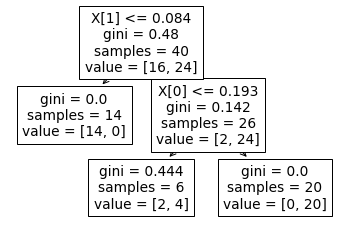

In [18]:
from sklearn import tree

tree.plot_tree(modelToInterpret) 



In [19]:
# Get explanation
explainer = TabularExplainer(modelToInterpret, X_train, features=['SuvInFocus','TBR','isStentgraft','isY','ageInYearsWhenSurgery'
     ,'isMale'], classes=['noInfection', 'infection'])
explanation = explainer.explain_global(X_test)

#Get an Explanation Client and upload the explanation
explain_client = ExplanationClient.from_run(run)
explain_client.upload_model_explanation(explanation, comment='Tabular Explanation')
explain_client.list_model_explanations()

Setting feature_perturbation = "tree_path_dependent" because no background data was given.
INFO:interpret_community.TabularExplainer:Initialized valid explainer TreeExplainer with args {'explain_subset': None, 'features': ['SuvInFocus', 'TBR', 'isStentgraft', 'isY', 'ageInYearsWhenSurgery', 'isMale'], 'classes': ['noInfection', 'infection']}


[{'id': '12b29566-8399-4707-8a5f-a4c01cd6199b',
  'comment': 'Tabular Explanation',
  'data_type': 'tabular',
  'explain_type': 'shap_tree',
  'model_type': 'classification',
  'is_raw': 'False',
  'is_engineered': 'False',
  'upload_time': datetime.datetime(2021, 4, 25, 10, 55, 12, 658795, tzinfo=<isodate.tzinfo.Utc object at 0x7fdda4a8fdc0>)},
 {'id': 'ccea510e-ac90-456b-b471-8ce7728a5b03',
  'comment': 'Tabular Explanation',
  'data_type': 'tabular',
  'explain_type': 'shap_tree',
  'model_type': 'classification',
  'is_raw': 'False',
  'is_engineered': 'False',
  'upload_time': datetime.datetime(2021, 4, 25, 11, 50, 43, 445734, tzinfo=<isodate.tzinfo.Utc object at 0x7fdda4a8fdc0>)}]

In [20]:
# Create a Python environment for the experiment
explain_env = Environment("explain-env")

# Create a set of package dependencies (including the azureml-interpret package)
packages = CondaDependencies.create(conda_packages=['scikit-learn','pandas','pip'],
                                    pip_packages=['azureml-defaults','azureml-interpret'])
explain_env.python.conda_dependencies = packages


ds = ws.datasets.get("mainMlDataSet")

max_depth = bestRunDetails[3]
min_samples_split = bestRunDetails[5]
min_impurity_decrease = bestRunDetails[7]

# Create a script config
script_config = ScriptRunConfig(source_directory=experiment_folder,
                      script='vascProsth_training.py'
                      ,arguments=['--input-data', ds.as_named_input('training_data')
                                 ,'--max_depth',max_depth
                                 ,'--min_samples_split',min_samples_split
                                 ,  '--min_impurity_decrease',min_impurity_decrease
                                  ,'--isToExplain',True
                                 ],
                       environment=explain_env) 

# submit the experiment
experiment_name = 'mslearn-vascProsth-explain'
experiment = Experiment(workspace=ws, name=experiment_name)
run = experiment.submit(config=script_config)
RunDetails(run).show()
run.wait_for_completion()

INFO:azureml.core.script_run_config:ScriptRunSubmit


_UserRunWidget(widget_settings={'childWidgetDisplay': 'popup', 'send_telemetry': False, 'log_level': 'INFO', '…

{'runId': 'mslearn-vascProsth-explain_1619351451_ec71094e',
 'target': 'local',
 'status': 'Finalizing',
 'startTimeUtc': '2021-04-25T11:50:54.118333Z',
 'properties': {'_azureml.ComputeTargetType': 'local',
  'ContentSnapshotId': '342be5e3-88d0-4d8a-a525-b7887bede9e2'},
 'inputDatasets': [{'dataset': {'id': '54697043-a8c4-41a1-a4fa-7c3da3ba435a'}, 'consumptionDetails': {'type': 'RunInput', 'inputName': 'training_data', 'mechanism': 'Direct'}}],
 'outputDatasets': [],
 'runDefinition': {'script': 'vascProsth_training.py',
  'command': '',
  'useAbsolutePath': False,
  'arguments': ['--input-data',
   'DatasetConsumptionConfig:training_data',
   '--max_depth',
   '5',
   '--min_samples_split',
   '7',
   '--min_impurity_decrease',
   '5E-05',
   '--isToExplain',
   'True'],
  'sourceDirectoryDataStore': None,
  'framework': 'Python',
  'communicator': 'None',
  'target': 'local',
  'dataReferences': {},
  'data': {'training_data': {'dataLocation': {'dataset': {'id': '54697043-a8c4-41a1-

In [21]:
# Get the feature explanations
client = ExplanationClient.from_run(run)
engineered_explanations = client.download_model_explanation()
feature_importances = engineered_explanations.get_feature_importance_dict()

# Overall feature importance
print('Feature\tImportance')
for key, value in feature_importances.items():
    print(key, '\t', value)

Feature	Importance
TBR 	 0.40010683760683763
SuvInFocus 	 0.08764245014245015
isMale 	 0.0
ageInYearsWhenSurgery 	 0.0
isY 	 0.0
isStentgraft 	 0.0
